In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import cvxpy as cvx
from pprint import pprint
from random import shuffle

In [2]:
cash_vector = np.random.normal(10000, 10000, 100)
cash_vector[cash_vector <= 0] = 1*10**-10
# cash_vector[cash_vector > 5000] = 6500
cash_to_connectivity = lambda x: np.log(x).astype(int)
connectivity_vector = cash_to_connectivity(cash_vector)

In [3]:
def make_connections(connectivity_vector, randomize=False, probabilities=True):
    size = connectivity_vector.shape[0]
    connections = cvx.Variable(size, size)
    objective = cvx.Minimize(cvx.sum_entries(connections))

    constraints = [connections[i, i] == 1 for i in range(size)]
    for i, connection in enumerate(connectivity_vector):
        connection_constraint = cvx.sum_entries(connections[i, :]) + cvx.sum_entries(connections[:, i]) >= connection
        constraints.append(connection_constraint)

    for i in range(size):
        for j in range(size):
            lt_one_constraint = connections[i, j] <= 1
            constraints.append(lt_one_constraint)

    problem = cvx.Problem(objective, constraints)
    problem.solve()

    real_connections = connections.value
    if probabilities:
        return real_connections
    
    adj_mat = np.zeros((size, size))
    inds = range(size)
    if randomize:
        shuffle(inds)
    for i in inds:
        connection = connectivity_vector[i]
        connection = max(0, int(connection - adj_mat[i, :].sum()))
        max_connection_inds = real_connections[i].argsort()[::-1]
        max_connection_inds = max_connection_inds[0, :connection]
        for j in max_connection_inds:
            adj_mat[i, j] = 1
    return adj_mat


def binarize_probabilities(mat):
    num_probs = mat.shape[0] * mat.shape[1]
    probs = np.random.uniform(size=num_probs).reshape(mat.shape)

    bin_mat = np.zeros_like(mat)
    for i in xrange(mat.shape[0]):
        for j in xrange(mat.shape[1]):
            bin_mat[i, j] = 1 if probs[i, j] < mat[i, j] else 0
    return bin_mat

In [4]:
c = make_connections(connectivity_vector)
c = binarize_probabilities(c)

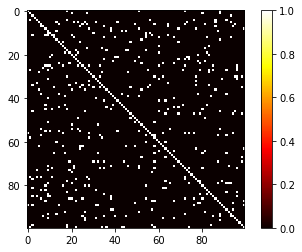

In [5]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_aspect('equal')
plt.imshow(c, interpolation='nearest', cmap=plt.cm.hot)
plt.colorbar()
plt.show()